In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, Birch, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import silhouette_visualizer
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

In [5]:
ds = pd.read_csv('movies.csv', encoding='latin1', sep=",")
ds.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
ds.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   budget    6820 non-null   float64
 1   company   6820 non-null   object 
 2   country   6820 non-null   object 
 3   director  6820 non-null   object 
 4   genre     6820 non-null   object 
 5   gross     6820 non-null   float64
 6   name      6820 non-null   object 
 7   rating    6820 non-null   object 
 8   released  6820 non-null   object 
 9   runtime   6820 non-null   int64  
 10  score     6820 non-null   float64
 11  star      6820 non-null   object 
 12  votes     6820 non-null   int64  
 13  writer    6820 non-null   object 
 14  year      6820 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


c:\users\doubl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [4]:
(ds==0).sum(axis=0)

budget      2182
company        0
country        0
director       0
genre          0
gross          0
name           0
rating         0
released       0
runtime        0
score          0
star           0
votes          0
writer         0
year           0
dtype: int64

In [5]:
ds.describe(include="all")

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
count,6.820000e+03,6820,6820,6820,6820,6.820000e+03,6820,6820,6820,6820.00000,6820.000000,6820,6.820000e+03,6820,6820.000000
unique,NaN,2179,57,2759,17,NaN,6731,13,2403,NaN,NaN,2504,NaN,4199,NaN
top,NaN,Universal Pictures,USA,Woody Allen,Comedy,NaN,Hamlet,R,1991-10-04,NaN,NaN,Nicolas Cage,NaN,Woody Allen,NaN
freq,NaN,302,4872,33,2080,NaN,3,3392,10,NaN,NaN,42,NaN,32,NaN
mean,2.458113e+07,NaN,NaN,NaN,NaN,3.349783e+07,NaN,NaN,NaN,106.55132,6.374897,NaN,7.121952e+04,NaN,2001.000293
std,3.702254e+07,NaN,NaN,NaN,NaN,5.819760e+07,NaN,NaN,NaN,18.02818,1.003142,NaN,1.305176e+05,NaN,8.944501
min,0.000000e+00,NaN,NaN,NaN,NaN,7.000000e+01,NaN,NaN,NaN,50.00000,1.500000,NaN,2.700000e+01,NaN,1986.000000
25%,0.000000e+00,NaN,NaN,NaN,NaN,1.515839e+06,NaN,NaN,NaN,95.00000,5.800000,NaN,7.665250e+03,NaN,1993.000000
50%,1.100000e+07,NaN,NaN,NaN,NaN,1.213568e+07,NaN,NaN,NaN,102.00000,6.400000,NaN,2.589250e+04,NaN,2001.000000
75%,3.200000e+07,NaN,NaN,NaN,NaN,4.006534e+07,NaN,NaN,NaN,115.00000,7.100000,NaN,7.581225e+04,NaN,2009.000000


<AxesSubplot:>

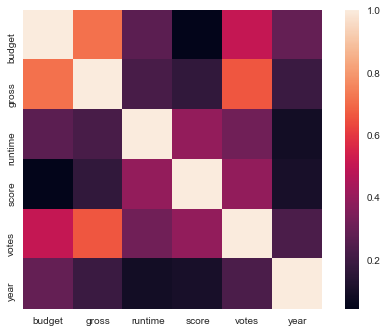

In [6]:
ds_corr = ds[["budget", "gross", "runtime", "score", "votes", "year"]]
cor = ds_corr.corr()
sns.heatmap(cor, square = True)

In [55]:
def prepare_data(dataset):
    dataset_copy = ds.copy()
    
    dataset_copy["budget"].replace(0, np.nan, inplace=True)
    dataset_copy["budget"].fillna(dataset_copy["budget"].sum() / dataset_copy["gross"].sum() * dataset_copy["gross"], inplace=True)
    
    dataset_copy = dataset_copy[~dataset_copy["rating"].isin(["NOT RATED", "UNRATED", "Not specified"])]
    dataset_copy["gross_to_budget_ratio"] = dataset_copy["gross"] / dataset_copy["budget"]
    
    le = LabelEncoder()
    dataset_copy["genre"] = le.fit_transform(dataset_copy["genre"])
    dataset_copy["rating"] = le.fit_transform(dataset_copy["rating"])
    dataset_copy["country"] = le.fit_transform(dataset_copy["country"])
    
    dataset_copy = dataset_copy.drop(columns=["released", "name", "company", "director", "star", "writer"])
    
    sc_X = StandardScaler()
    dataset_copy[dataset_copy.columns] = sc_X.fit_transform(dataset_copy[dataset_copy.columns])
    
    return dataset_copy

In [56]:
test = prepare_data(ds)
test.head()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [9]:
def doPCA(dataset):
    #Creating a model
    pca = PCA(n_components=dataset.shape[1], random_state=0)

    #Fitting to the model
    pca.fit(dataset)

    #Generating all components in an array
    X_pca = pca.transform(dataset)
    # X_pca_output = pd.DataFrame(X_pca)

    #Displaying the explained variance by number of components
    for n in range(0, dataset.shape[1]):
        print(f"Variance explained by the first {n+1} principal components = {np.cumsum(pca.explained_variance_ratio_ *100)[n]:.1f}%")
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")

    pca_selected = PCA(n_components=10, random_state=0)
    pca_selected.fit(dataset)
    X_pca_selected = pca_selected.transform(dataset)
    
    return X_pca_selected

In [10]:
def siluete(data):
    for i in range(2, 10):
        model = KMeans(n_clusters=i, init="k-means++", max_iter=1000, random_state=1).fit(data)
        target_predicted = model.labels_
        score = silhouette_score(data, target_predicted)
        print(f"Silhouette score for {i} clusters: {score}")

In [11]:
dtest = prepare_data(ds)
siluete(dtest)

Silhouette score for 2 clusters: 0.35752260710251993
Silhouette score for 3 clusters: 0.35723902338361346
Silhouette score for 4 clusters: 0.2680176116563134
Silhouette score for 5 clusters: 0.16422618964427074
Silhouette score for 6 clusters: 0.15820187362053292
Silhouette score for 7 clusters: 0.1593651854069764
Silhouette score for 8 clusters: 0.1657016831752873
Silhouette score for 9 clusters: 0.16324587447393066


In [224]:
def silhouetteMethod(X_pca_selected, ds_orig):
    silhouette_coefficients = []
    for j in range(2, 21):
        km = KMeans(n_clusters=j, init="random", n_init=10, max_iter=300, tol=1e-04, random_state=0)
        km.fit(X_pca_selected)
        score = silhouette_score(X_pca_selected, km.labels_)
        silhouette_coefficients.append(score)

    #Plotting

    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 21), silhouette_coefficients)
    plt.xticks(range(2, 21))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

    #Choosing number of clusters

    n_clusters = 5
    print('Estimated number of clusters: %d' % n_clusters)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X_pca_selected)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X_pca_selected, km.fit(X_pca_selected).labels_))

    #Plotting chosen number of clusters
    silhouette_visualizer(KMeans(n_clusters=n_clusters, random_state=0), X_pca_selected)

    #Visualizing clusters in the dataset
    X_orig = pd.DataFrame(ds_orig)
    X_orig["cluster"] = km.labels_

In [225]:
def elbowMethod(dataset):
    k_rng = range(1, 10)
    sse_scaler = []
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(dataset)
        sse_scaler.append(km.inertia_)
        
    plt.plot(k_rng,sse_scaler)
    plt.xlabel("k")
    plt.ylabel("Sum of squared error")
    
    kl = KneeLocator(range(1, 10), sse_scaler, curve="convex", direction="decreasing")
    num = kl.elbow
    print(f"Recommended number of clusters: {num}")

Recommended number of clusters: 4


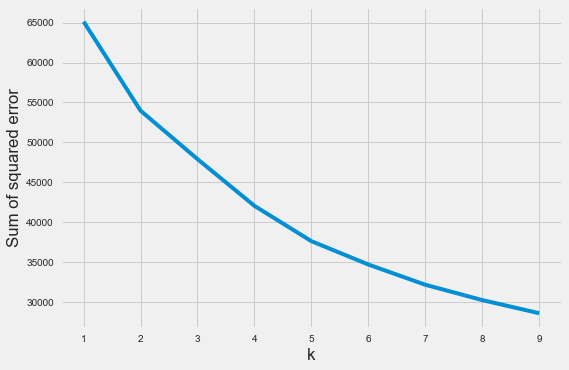

In [226]:
ds_cp = prepare_data(ds)
elbowMethod(ds_cp)

In [227]:
def doKmeans(dataset, nclust):
    model = KMeans(nclust, init='k-means++', max_iter=10000)
    model.fit(dataset)
    clust_labels = model.predict(dataset)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [47]:
def meanshift_outlier_elimination(data, pca_model, min_count, display):
    mshift = MeanShift()
    indexes = mshift.fit_predict(data)
    destinations = mshift.cluster_centers_
    
    k = destinations.shape[0]
    
    destinations_count = np.array([(indexes == i).sum() for i in (range(k))])
    print("Mean shift elimination:")
    print(destinations_count)
    destinations_marker = destinations_count >= min_count
    data_marker = destinations_marker[indexes]

    good_data = data[data_marker]
    bad_data = data[np.invert(data_marker)]
    
    if display:
        good_data_pca = pca_model.transform(good_data)
        if bad_data.shape[0] > 0:
            bad_data_pca = pca_model.transform(bad_data)

        fig = plt.figure()
        axes = Axes3D(fig)
        axes.scatter(good_data_pca[:, 0], good_data_pca[:, 1], good_data_pca[:, 2], color="b")
        if bad_data.shape[0] > 0:
            axes.scatter(bad_data_pca[:, 0], bad_data_pca[:, 1], bad_data_pca[:, 2], color="r")
        plt.show()
    
    return good_data, destinations_marker.sum()

Mean shift elimination:
[6334   18   13    2   19    1    1    1  101    1    1    7    1    9
    1    1    1]


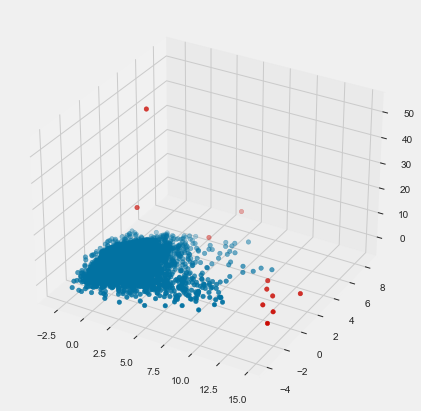

Mean shift elimination:
[6320    8   36   19  102    7    9]


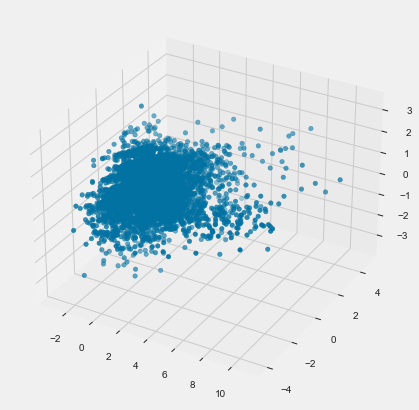

Mean shift elimination:
[6320    8   36   19  102    7    9]


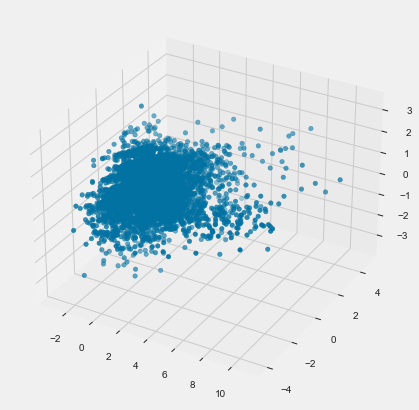

Mean shift elimination:
[6320    8   36   19  102    7    9]


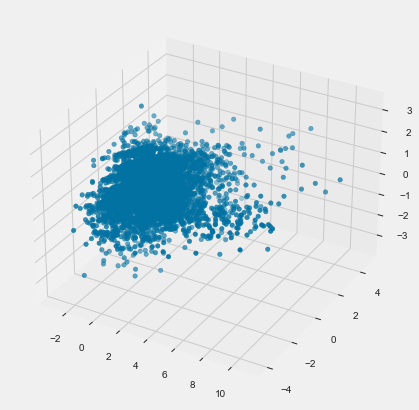

Mean shift elimination:
[6320    8   36   19  102    7    9]


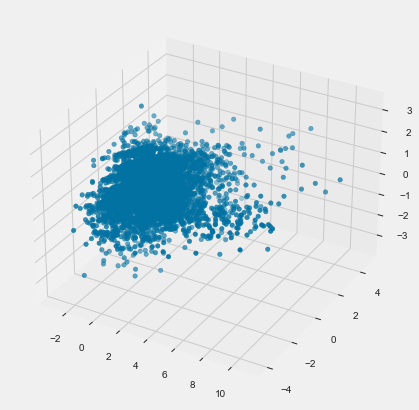

Clusters: 7


In [229]:
test_data = prepare_data(ds)
pca_model = PCA(n_components=3)
pca_model.fit(test_data)


clusters = -1
for i in range(5):
    test_data, clusters = meanshift_outlier_elimination(test_data, pca_model, 5, display=True)
    
print(f"Clusters: {clusters}")

10
Variance explained by the first 1 principal components = 28.0%
Variance explained by the first 2 principal components = 43.5%
Variance explained by the first 3 principal components = 53.9%
Variance explained by the first 4 principal components = 63.7%
Variance explained by the first 5 principal components = 73.3%
Variance explained by the first 6 principal components = 81.8%
Variance explained by the first 7 principal components = 88.2%
Variance explained by the first 8 principal components = 94.5%
Variance explained by the first 9 principal components = 97.8%
Variance explained by the first 10 principal components = 100.0%


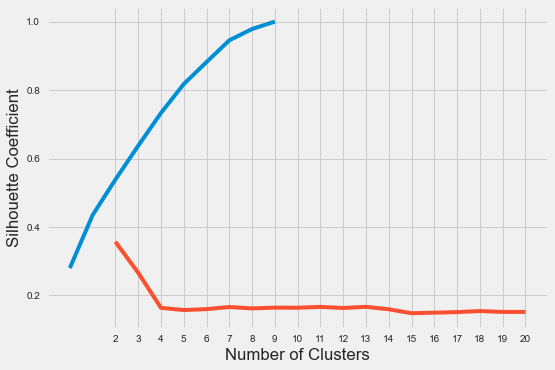

Estimated number of clusters: 5
Silhouette Coefficient: 0.164


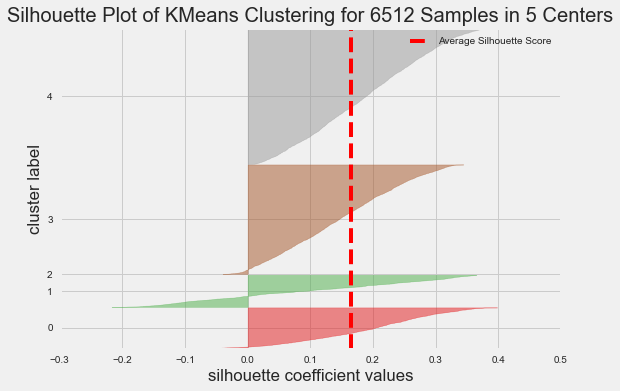

10


,budget,country,genre,gross,rating,runtime,score,votes,year,gross_to_budget_ratio,cluster,kmeans
0,-0.523655,0.408627,-1.033922,0.291753,0.780202,-0.988426,1.751325,1.696032,-1.668302,0.033729,1,3.0
1,-0.577821,0.408627,0.113601,0.593732,-0.334959,-0.192468,1.451579,1.437072,-1.668302,0.088509,1,3.0
2,-0.334074,0.408627,-1.416429,2.449099,-1.450120,0.205511,0.552342,1.227769,-1.668302,0.091670,2,1.0
3,-0.239283,0.408627,-1.416429,0.847915,0.780202,1.740573,2.051071,3.508301,-1.668302,0.013185,2,1.0
4,-0.496572,0.408627,-1.033922,-0.278790,-1.450120,-0.931572,0.552342,-0.278379,-1.668302,-0.013820,4,2.0


In [153]:
ds_cp = prepare_data(ds)
print(ds_cp.shape[1])
ds_cp.head()
ds_cp_pca = doPCA(ds_cp)
silhouetteMethod(ds_cp_pca, ds_cp)
print(ds_cp_pca.shape[1])
clust_labels, cent = doKmeans(ds_cp, 5)
kmeans = pd.DataFrame(clust_labels)
ds_cp.insert((ds_cp.shape[1]), 'kmeans', kmeans)

ds_cp.head()

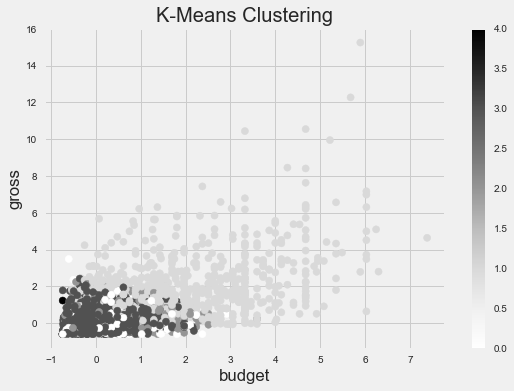

In [154]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(ds_cp["budget"],ds_cp["gross"],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('budget')
ax.set_ylabel('gross')
plt.colorbar(scatter)

In [60]:
def do_dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clustering_labels = dbscan.fit_predict(data)
    
    pca_model = PCA(n_components=3)
    pca_model.fit(data)
    data_pca = pca_model.fit_transform(data)
    
#     colors_array = []
#     colors_array_dark = []

    labels = dbscan.labels_
#     k = len(set(labels)) - (1 if -1 in labels else 0)
#     for i in range(k):
#         colors_array.append(colors.hsv_to_rgb([i / k, 1, 1]))
#         colors_array_dark.append(colors.hsv_to_rgb([i / k, 1, 0.2]))

#     colors_array_dark = np.array(colors_array_dark)

#     fig = plt.figure()
#     axes = Axes3D(fig)
#     axes.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], color=colors_array_dark[clustering_labels])
#     plt.show()
    
    data['labels'] = clustering_labels
    print(clustering_labels)
#     score = silhouette_score(data, data['labels'])
#     print(f"Silhouette score for eps={eps}: {score}")
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    return data

In [63]:
dstest1 = prepare_data(ds)
tst = do_dbscan(dstest1, 7, 20)
tst.describe()

[0 0 0 ... 0 0 0]
Estimated number of clusters: 1
Estimated number of noise points: 2


,budget,country,genre,gross,rating,runtime,score,votes,year,gross_to_budget_ratio,labels
count,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6.512000e+03,6512.000000
mean,3.491610e-17,-1.702160e-16,-2.618708e-17,-6.983221e-17,-1.352999e-16,1.265709e-16,5.586577e-16,1.745805e-17,1.815637e-15,-4.910077e-18,-0.000307
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,0.017524
min,-7.403179e-01,-3.627627e+00,-1.416429e+00,-5.928762e-01,-5.910763e+00,-3.205737e+00,-4.843083e+00,-5.536962e-01,-1.668302e+00,-3.574601e-02,-1.000000
25%,-6.483780e-01,3.310066e-01,-1.033922e+00,-5.580433e-01,-3.349592e-01,-6.473008e-01,-6.466415e-01,-4.940137e-01,-8.853689e-01,-2.921959e-02,0.000000
50%,-3.340738e-01,4.086269e-01,1.136010e-01,-3.614678e-01,7.802016e-01,-2.493218e-01,5.276545e-02,-3.473193e-01,9.412241e-03,-2.126058e-02,0.000000
75%,2.075868e-01,4.086269e-01,8.786161e-01,1.189159e-01,7.802016e-01,4.329279e-01,7.521724e-01,4.476642e-02,9.041934e-01,-2.059036e-02,0.000000
max,7.384590e+00,4.862471e-01,4.703692e+00,1.525414e+01,4.125684e+00,1.476017e+01,2.950308e+00,1.344672e+01,1.687127e+00,7.644095e+01,0.000000


In [44]:
def do_mean_shift(data):
    bandwidth = estimate_bandwidth(data, quantile=0.8, random_state=2021)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)
    indexes = ms.fit_predict(data)
    
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print("number of estimated clusters : %d" % n_clusters_)
    
    
    pca_model = PCA(n_components=3)
    pca_model.fit(data)
    data_pca = pca_model.fit_transform(data)
    
    colors_array = []
    colors_array_dark = []
    for i in range(n_clusters_):
        colors_array.append(colors.hsv_to_rgb([i / n_clusters_, 1, 1]))
        colors_array_dark.append(colors.hsv_to_rgb([i / n_clusters_, 1, 0.2]))
    colors_array = np.array(colors_array)

    fig = plt.figure()
    axes = Axes3D(fig)
    axes.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], color=colors_array[indexes])
    plt.show()

number of estimated clusters : 5


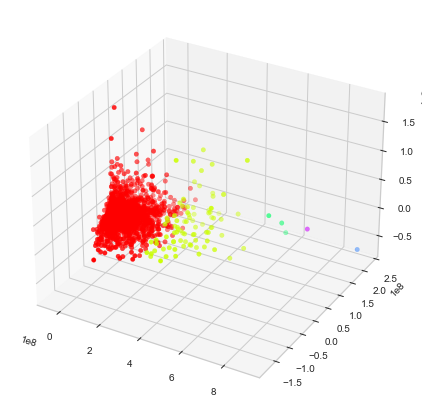

In [45]:
tst123 = prepare_data(ds)
do_mean_shift(tst123)

Mean shift elimination:
[5936  248  151   30   10   27   23    9    6    6   47]


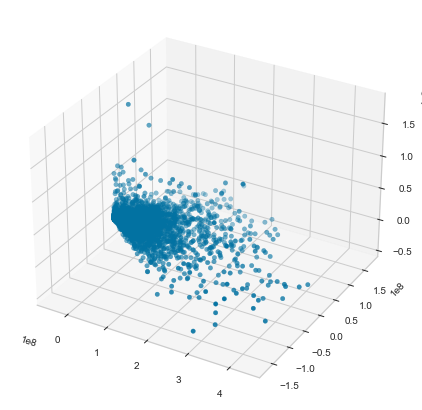

number of estimated clusters : 1


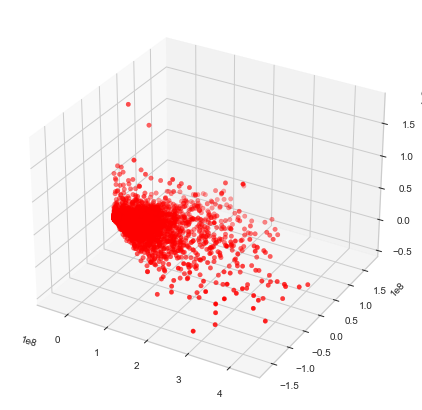

In [52]:
pca_model = PCA(n_components=3)
pca_model.fit(tst123)

tst123, clusters = meanshift_outlier_elimination(tst123, pca_model, 5, display=True)
do_mean_shift(tst123)